In [1]:
import sys
import time
import numpy as np
import pandas as pd
sys.path.append("..")
from tma.model import Model
from tma.objects import Target, Observer
from tma.algorithms import Algorithms, Swarm
from tma.helper_functions import df_to_docx
from pathlib import Path
from datetime import datetime
from functools import partial

Создаем модель наблюдателя:

In [9]:
print("Время последнего моделирования:", datetime.now().strftime("%d/%m/%Y %H:%M\n"))

observer_x, observer_y, observer_course, observer_velocity = 0.0, 0.0, 0.0, 3.0
observer = Observer(observer_x, observer_y, observer_course,
                observer_velocity, verbose=True)

observer.forward_movement(2 * 60)
observer.change_course(270, 'left', omega=0.5)
observer.forward_movement(3 * 60)
observer.change_course(90, 'right', omega=0.5)
observer.forward_movement(2 * 60)

Время последнего моделирования: 18/05/2021 18:14

Наблюдатель имеет начальные параметры (0.0, 0.0, 0.0, 3.0)
Наблюдатель движется прямо по курсу 0.0° 120с
Наблюдатель перешёл на курс 270.0° (угловая скорость 0.5) за 180с
Наблюдатель движется прямо по курсу 270.0° 180с
Наблюдатель перешёл на курс 90.0° (угловая скорость 0.5) за 360с
Наблюдатель движется прямо по курсу 90.0° 120с


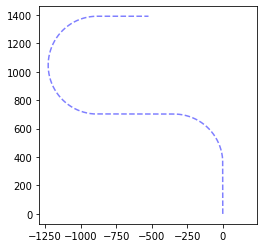

In [10]:
from tma.plot import plot_trajectory
plot_trajectory(observer)

Задаем априорные данные, вектор дистанций, вектор СКО

In [4]:
p0 = [0.0, 25.0, 90.0, 7.0]
std_arr = [0.0, 0.1, 0.2, 0.3, 0.5, 1.0]
d_ranges = [(10, 20), (20, 30), (30, 40), (40, 50), (10, 50)]
def target_func(d1, d2, seed=None):
    rng = np.random.RandomState(seed)
    b = 0
    d = rng.uniform(d1, d2)
    c = rng.uniform(0, 180)
    v = rng.uniform(5, 15)
    return [b, d, c, v]
result_df = pd.DataFrame(columns=[
                                'Диапазон Д0', 'СКО', 
                                'Рэф1', 'Рэф2', 'Рэф3', 'Рэф4', 'Рэф5', 
                                'Ка', 'Вычисления', 'Вычисления макс', 'Итерации', 
                                'Итерации макс', 'Время', 'Время макс',
                                ])
mean_columns = ['Ка', 'Вычисления', 'Итерации', 'Время']
max_columns = ['Вычисления', 'Итерации', 'Время']
new_max_columns = [i + ' макс' for i in max_columns]
Path("../tests/test7").mkdir(parents=True, exist_ok=True)

Запускаем множество моделей для каждого СКО

In [5]:
%%time
model = Model(observer)
for d_range in d_ranges:
    for std in std_arr:  
        f = partial(target_func, *d_range)
        model.noise_std = np.radians(std)
        swarm = Swarm(model)
        swarm.set_algorithm('ММП')
        swarm.set_target_func(f)
        swarm.set_initial(p0)
        r = swarm.run()
        df = swarm.get_df(r)
        df.to_excel('../tests/test7/' '2г, ' + str(d_range) + ', ' + str(std) + '.xlsx', index=False)
        res = pd.DataFrame({'СКО': [std], 'Диапазон Д0': [d_range]})
        for i in range(5):
            res['Рэф' + str(i + 1)] = [df['Успех'].apply(lambda x: x[i]).mean(axis=0)]
        res[mean_columns] = df[mean_columns].mean(axis=0)
        res[new_max_columns] = df[max_columns].apply(max, axis=0)
        result_df = result_df.append(res)

Wall time: 26.8 s


In [6]:
result_df['Ка'] = result_df['Ка'].apply(np.sqrt)
result_df.rename(columns={'Ка': 'КKa'}, inplace=True)
result_df.reset_index(drop=True, inplace=True)

In [7]:
display_df = result_df.copy()
precisions = {
                'КKa' : '{0:.2f}', 
                'Вычисления' : '{0:.0f}', 
                'Вычисления макс': '{0:.0f}',
                'Итерации' : '{0:.0f}', 
                'Итерации макс' : '{0:.0f}', 
                'Время' : '{0:.4f}', 
                'Время макс' : '{0:.4f}',
            }
for col, precision in precisions.items():
    display_df[col] = display_df[col].apply(lambda x: precision.format(x))
df_to_docx(display_df, f'../tests/test7/Сводная таблица 2г.docx')
display_df

,Диапазон Д0,СКО,Рэф1,Рэф2,Рэф3,Рэф4,Рэф5,КKa,Вычисления,Вычисления макс,Итерации,Итерации макс,Время,Время макс
0,"(10, 20)",0.0,1.00,1.00,1.00,1.00,1.00,0.00,18,31,15,24,0.0038,0.0090
1,"(10, 20)",0.1,0.95,0.99,0.99,1.00,1.00,0.10,18,31,14,24,0.0036,0.0075
2,"(10, 20)",0.2,0.82,0.97,0.97,0.99,0.99,0.20,17,31,14,24,0.0042,0.0100
3,"(10, 20)",0.3,0.71,0.88,0.89,0.97,0.99,0.30,18,31,14,24,0.0039,0.0091
4,"(10, 20)",0.5,0.46,0.76,0.76,0.87,0.94,0.50,18,31,14,24,0.0047,0.0183
5,"(10, 20)",1.0,0.26,0.49,0.50,0.69,0.76,1.00,18,31,15,24,0.0047,0.0186
6,"(20, 30)",0.0,1.00,1.00,1.00,1.00,1.00,0.00,11,24,10,19,0.0030,0.0119
7,"(20, 30)",0.1,0.87,0.99,0.99,0.99,0.99,0.10,11,24,10,19,0.0026,0.0046
8,"(20, 30)",0.2,0.64,0.88,0.88,0.97,0.99,0.20,11,24,10,19,0.0027,0.0110
9,"(20, 30)",0.3,0.47,0.75,0.76,0.88,0.95,0.30,11,24,10,19,0.0028,0.0068
